Project: Forecasting short term solar energy
The data is taken from AMS 2013-2014 solar energy prediction contest input datset posted at the kaggle website.
First We will prepare the precipitation data

In [2]:
# import necessary modules
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
from scipy import interpolate
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
# load dataset and select the necessary variable to process

# finding data variables and their structure
data = nc.Dataset("C:\\Users\\manas\\Desktop\\Springboard\\Capstone ideas\\Solar energy\\gefs_train\\train\\tmp_2m_latlon_subset_19940101_20071231.nc")
for v in data.variables.keys():
    print(v)

#print(data.variables.values())

for d in data.dimensions.values():
    print(d)

lat = data.variables['lat']
print(lat.shape)
lon = data.variables['lon']
print(lon.shape)
t = data.variables['Temperature_height_above_ground']
print(t.shape)
l = lat[:]
n = lon[:]



time
intTime
lat
lon
ens
fhour
intValidTime
Temperature_height_above_ground
<class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 5113

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 9

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 16

<class 'netCDF4._netCDF4.Dimension'>: name = 'ens', size = 11

<class 'netCDF4._netCDF4.Dimension'>: name = 'fhour', size = 5

(9,)
(16,)
(5113, 11, 5, 9, 16)


Method: We need the grid points from lat: 33 - 37 (5), lon: 257 - 266 (10), so 5 x 10 = 50 grid points instead of 9 x 16 grid points.
We have to loop under loop to create data at each grid point. 
First the data is extracted for each grid points and down to dimension (5113, 11, 5). 
Initial data cleaning and quality chacking is done.
1. null value check
2. minimum and maximum value, standard deviation
3. outlier checking from histogram
4. boxplot
Then the average over 11 model is done resulting a matrix of (5113, 5). Then averaging on 5 time steps are done to get the daily avg (5113). 
Then variables at individual station is estmated by 2d interpolation


In [4]:
## Reshaping data file for a smaller grid (latitude range 33 - 38, longitude range 257 - 267) which cover all stations
for lat in range(33, 38): 
    l_in = np.where(l == lat)[0][0]
    for lon in range(257, 267):
        n_in = np.where(n == lon)[0][0]
        filename = 't_'+str(lat)+ '_'+str(lon)
        fileval = t[:,:,:,l_in,n_in]
        #print(filename, fileval.shape)
        # reshaping fileval from (5113, 11, 5) to (5113, 55)
        fileval = fileval.reshape(fileval.shape[0], fileval.shape[1]*fileval.shape[2])
        #print(filename, fileval.shape)
        # saving the  data for each grid point
        filepath = "C:/Users/manas/Desktop/Springboard/Capstone ideas/Solar energy/Data/Temp/" + filename +str('.csv')
        np.savetxt(filepath, fileval, delimiter=',', fmt = "%0.06f")


lattitude and longitude of the station: [34.80833, 261.97675]
lattitude and longitude of surrounding grids are (in format lat_lon): ['34_261', '34_262', '35_261', '35_262']

Summary statistics of the variable at 4 surrounding grid points:
              34_261         34_262         35_261         35_262
25%       284.460877     284.248413     282.705627     282.706039
50%       293.255188     292.794434     291.554657     291.388428
75%       301.054902     300.115097     299.660324     298.935105
count  281215.000000  281215.000000  281215.000000  281215.000000
max       319.109375     317.148987     318.041870     315.309387
mean      292.625242     292.044616     291.083037     290.666603
min       250.836716     253.031235     250.076721     248.564392
std        10.714237      10.319384      10.948172      10.550301

Correlation of the surrounding grid variables:
          34_261    34_262    35_261    35_262
34_261  1.000000  0.996846  0.995620  0.994998
34_262  0.996846  1.00000

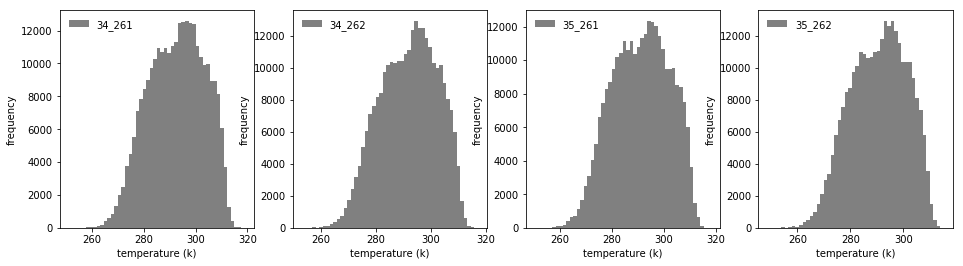

In [31]:
# Focusing on 1 station at a time
#picking 4 surrounding grid points to the station

# loading the station_info file with lattitude and longitude of each station
def station_n_l_e(station_name):
    station_loc = pd.read_csv("C:\\Users\\manas\\Desktop\\Springboard\\Capstone ideas\\Solar energy\\station_info.csv", index_col='stid')
    stn_n_l_e = station_loc.loc[station_name]
    stn_n = stn_n_l_e[0]
    stn_l = stn_n_l_e[1] + 360
    return [stn_n, stn_l]

# Calling function for a given station: ACME
list1 = station_n_l_e('ACME')

Xnew=list1[1]
Ynew=list1[0]

# lattitude longitude for the surrounding grids
str_list = [str(math.floor(Ynew)) +'_'+ str(math.floor(Xnew)), 
            str(math.floor(Ynew)) +'_'+ str(math.ceil(Xnew)), 
            str(math.ceil(Ynew)) +'_'+ str(math.floor(Xnew)), 
            str(math.ceil(Ynew)) +'_'+ str(math.ceil(Xnew))]
print('lattitude and longitude of the station:', list1)
print('lattitude and longitude of surrounding grids are (in format lat_lon):', str_list)

# setting filepath for the variable files at the surrounding grids
filepath = "C:\\Users\\manas\\Desktop\\Springboard\\Capstone ideas\\Solar energy\\Data\\Temp\\t_"
filename1 = filepath + str_list[0] + '.csv'
filename2 = filepath + str_list[1] + '.csv'
filename3 = filepath + str_list[2] + '.csv'
filename4 = filepath + str_list[3] + '.csv'
filenames = [filename1, filename2, filename3, filename4]

#creating subplots for histogram
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

p_des_con = pd.DataFrame()
avg_grid = pd.DataFrame()
# at each grid point surrounding the station
for k in range(4):
    
    p_grid = pd.read_csv(filenames[k], header=None)
    
    
    ## data quality check and cleaning
    
    # Null data
    assert pd.notnull(p_grid).all().all()
    
    # statistical summary
    
    # reshaping: from 2d:5113 x 55 to 1d: 281215
    p = p_grid.melt()
    p_des = p.describe().value
    p_des_con = pd.concat([p_des_con, p_des], axis=1 )
    
    
    #Histogram of the variable    
    ax = axes[k]
    ax.hist(p['value'], bins=50, color='gray', label=str_list[k])
    ax.set_xlabel('temperature (k)')
    ax.set_ylabel('frequency')
    leg=ax.legend(loc='upper left')
    leg.draw_frame(False)
    
    #p.boxplot(column='value')

    # Averaging data over model estimation and timesteps
    # There are 5 timesteps in a day (lets say: t0, t1, t2, t3, t4)
    # we will combine 11 model prediction at each timestep first and then average over time
       
    # looping over timesteps
    model_mean_t=pd.DataFrame()
    for j in range(0,5):
        
        model_en = p_grid[j]
        for i in range(0,50,5):
            model_en = pd.concat([model_en, p_grid[i+j+5]], axis=1)
        model_mean = np.mean(model_en, axis=1)
    
        model_mean_t = pd.concat([model_mean_t, model_mean], axis=1)
    
    # average the variable over timesteps
    model_mean_t_mean = np.mean(model_mean_t, axis=1)
    # concating vag from all 4 grids
    avg_grid = pd.concat([avg_grid, model_mean_t_mean], axis=1)
    
    # saving the averaged value from 4 surrounding grids
    filepath1 = "C:\\Users\\manas\\Desktop\\Springboard\\Capstone ideas\\Solar energy\\Data\\Temp\\model_t_mean_"
    filename= filepath1 + str_list[k] + '.csv'
    #print(filename)
    np.savetxt(filename, model_mean_t_mean, delimiter=',', fmt = "%0.06f")
    
p_des_con.columns = str_list
print('')
print('Summary statistics of the variable at 4 surrounding grid points:')
print(p_des_con)
avg_grid.columns = str_list

# evaluate correlation among the gridpoint variables
print('')
print('Correlation of the surrounding grid variables:')
print(avg_grid.corr())


Comment: There is no NULL data for station 'ACME' . The summary statistics from the surrounding grids are pretty similar. Also the frequency distribution (histogram) are quite similar. The correlation table shows a strong linear relation among the data from all grids. So the linear interpolation seems to be quite apt. 

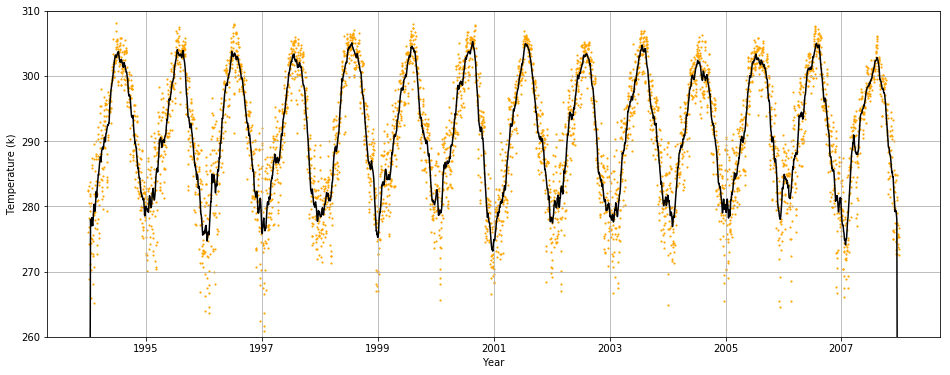

In [82]:
# Interpolating the variable values from 4 surrounding grid points to the station

x,y = np.meshgrid([math.floor(Xnew), math.ceil(Xnew)],[math.floor(Ynew), math.ceil(Ynew)])

#Setting filepath
# making str_list: math.floor(Xnew), math.ceil(Xnew), math.floor(Ynew), math.ceil(Ynew)
str_list = [str(math.floor(Ynew)) +'_'+ str(math.floor(Xnew)), 
            str(math.floor(Ynew)) +'_'+ str(math.ceil(Xnew)), 
            str(math.ceil(Ynew)) +'_'+ str(math.floor(Xnew)), 
            str(math.ceil(Ynew)) +'_'+ str(math.ceil(Xnew))]

filepath = "C:\\Users\\manas\\Desktop\\Springboard\\Capstone ideas\\Solar energy\\Data\\Temp\\model_t_mean_"
filename1 = filepath + str_list[0] + '.csv'
filename2 = filepath + str_list[1] + '.csv'
filename3 = filepath + str_list[2] + '.csv'
filename4 = filepath + str_list[3] + '.csv'
filenames = [filename1, filename2, filename3, filename4]

# loading data for surrounding grids
var1 = pd.read_csv(filename1, header=None)
var1 = var1.rename(columns={var1.columns[0] : 'x1y1'})
var2 = pd.read_csv(filename2, header=None)
var2 = var2.rename(columns={var2.columns[0] : 'x2y1'})
var3 = pd.read_csv(filename3, header=None)
var3 = var3.rename(columns={var3.columns[0] : 'x1y2'})
var4 = pd.read_csv(filename4, header=None)
var4 = var4.rename(columns={var4.columns[0] : 'x2y2'})
var = pd.concat([var1, var2, var3, var4], axis=1)

# interpolating to the station
# z structure([(34,261), (34, 262)], [(35, 261), (35, 262)])
var_station = []
for row in var.values:
    z = [row[0], row[1]], [row[2], row[3]]
    #print(z)
    f = interpolate.interp2d(x,y,z,kind='linear')
    interp_val=f(Xnew,Ynew)
    #print(type(interp_val))
    var_station = np.append(var_station, interp_val)
#print(var_station)
#print(type(var_station), type(Dates.values))

# saving interpolated station data
filepath_var = "C:\\Users\\manas\\Desktop\\Springboard\\Capstone ideas\\Solar energy\\Data\\Temp\\t_station.csv"
np.savetxt(filepath_var, var_station, delimiter=',', fmt = "%0.06f")

# plotting the variable and its moving average

## Convert Dates to datetime
dates = np.arange(np.datetime64('1994-01-01'), np.datetime64('2008-01-01'))

# esttimating the noving average
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

x = dates
y = var_station
plt.scatter(x, y, s=5, marker='.', color='orange')
plt.ylim(260,310)
plt.xlabel('Year')
plt.ylabel('Temperature (k)')
#plt.xticks(rotation=45)

y_av = movingaverage(y, 30)
plt.plot(x, y_av, color='black')
plt.rcParams["figure.figsize"] = [16,6]
plt.grid(True)
plt.show()

Comment: The interpolated data for individual station is saved in seperate files. Further analysis is done in different notebook.